In [1]:
# ==============================================================================
# CELLULE 1 : IMPORTS ET CONFIGURATION
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
import os

# Modèles
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métriques
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix

# Ajout du chemin vers tes scripts locaux (src)
sys.path.append('..')
from src.sampling import get_sample_weights

# Config
pd.set_option('display.max_columns', 50)
import warnings
warnings.filterwarnings('ignore')

print("✅ Environnement prêt (XGBoost + LightGBM).")

✅ Environnement prêt (XGBoost + LightGBM).


In [2]:
# ==============================================================================
# CELLULE 2 : CHARGEMENT ET PRÉPARATION
# ==============================================================================
print("1. Chargement des données...")

try:
    X = pd.read_parquet('../data/processed/train_stationary.parquet')
    y_data = pd.read_parquet('../data/processed/labels.parquet')
except FileNotFoundError:
    raise FileNotFoundError("❌ Fichiers introuvables. Lance les notebooks 02 et 03 d'abord.")

# Alignement
common_idx = X.index.intersection(y_data.index)
X = X.loc[common_idx]
y = y_data.loc[common_idx, 'bin']
events_meta = y_data.loc[common_idx]

# Calcul du proxy prix pour les poids
if 'forward_returns' in X.columns:
    price_proxy = (1 + X['forward_returns']).cumprod()
else:
    raise ValueError("Colonne 'forward_returns' manquante.")

# Nettoyage Anti-Leakage
cols_to_drop = ['forward_returns', 'market_forward_excess_returns', 
                'lagged_forward_returns', 'lagged_market_forward_excess_returns', 
                'risk_free_rate', 'date_id']
X = X.drop(columns=[c for c in cols_to_drop if c in X.columns])

print(f"Dataset prêt : {X.shape}")

1. Chargement des données...
Dataset prêt : (1917, 97)


In [3]:
# ==============================================================================
# CELLULE 3 : CALCUL DES POIDS (SAMPLE WEIGHTS)
# ==============================================================================
print("\n2. Calcul des Sample Weights...")
t1 = events_meta['t1']
w_raw = get_sample_weights(t1, price_proxy, events_meta, X.index)
w_raw = w_raw.fillna(w_raw.mean())

# Normalisation (Crucial pour XGB/LGBM)
w_all = w_raw / w_raw.mean()

print(f"Poids moyens : {w_all.mean():.4f}")


2. Calcul des Sample Weights...
Poids moyens : 1.0000


In [4]:
# ==============================================================================
# CELLULE 4 : SPLIT TRAIN / TEST (80/20)
# ==============================================================================
# On splitte AVANT la sélection de features pour éviter le 'Selection Bias'
split_point = int(len(X) * 0.80)

X_train_full, X_test_full = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
w_train = w_all.iloc[:split_point]

print(f"Split: Train={len(X_train_full)} | Test={len(X_test_full)}")

Split: Train=1533 | Test=384


In [5]:
# ==============================================================================
# CELLULE 5 : SÉLECTION DE FEATURES (TOP 20)
# ==============================================================================
print("\n3. Sélection des Features (Top 20)...")

# Modèle sélecteur rapide
selector = XGBClassifier(n_estimators=100, max_depth=4, n_jobs=-1, random_state=42)
selector.fit(X_train_full, y_train, sample_weight=w_train.values)

# Importance
importances = pd.DataFrame({'feature': X_train_full.columns, 'importance': selector.feature_importances_})
importances = importances.sort_values('importance', ascending=False)

TOP_N = 20
top_features = importances.head(TOP_N)['feature'].tolist()
print(f"✅ Features retenues : {top_features}")

# Filtrage
X_train = X_train_full[top_features]
X_test = X_test_full[top_features]


3. Sélection des Features (Top 20)...
✅ Features retenues : ['M18', 'P8', 'I9_ffd', 'D8', 'M9', 'M16', 'I4', 'P4', 'P10_ffd', 'E13', 'E10', 'M1', 'E9', 'E12', 'E4', 'P10_ffd_vol', 'E18', 'V9', 'V10', 'S10']


In [6]:
# ==============================================================================
# CELLULE 6 : ENTRAÎNEMENT DE L'ENSEMBLE (XGB + LGBM)
# ==============================================================================
print("\n4. Entraînement des Modèles (Ensemble)...")

# Calcul du ratio de classe pour l'équilibrage
scale_ratio = w_train[y_train == 0].sum() / w_train[y_train == 1].sum()

# --- MODÈLE A : XGBOOST ---
print(" -> Training XGBoost...")
model_xgb = XGBClassifier(
    n_estimators=1000, max_depth=4, learning_rate=0.02,
    subsample=0.7, colsample_bytree=0.7,
    gamma=0.5, reg_alpha=0.5,
    scale_pos_weight=scale_ratio,
    n_jobs=-1, random_state=42,
    early_stopping_rounds=50
)
model_xgb.fit(X_train, y_train, sample_weight=w_train.values, 
              eval_set=[(X_test, y_test)], verbose=False)

# --- MODÈLE B : LIGHTGBM ---
print(" -> Training LightGBM...")
model_lgb = LGBMClassifier(
    n_estimators=1000, max_depth=4, learning_rate=0.02,
    subsample=0.7, colsample_bytree=0.7,
    scale_pos_weight=scale_ratio,
    n_jobs=-1, random_state=42, verbose=-1
)
# LightGBM gère l'early stopping via callbacks dans les versions récentes, 
# ou on peut le laisser fitter tout (il est robuste). On fait simple.
model_lgb.fit(X_train, y_train, sample_weight=w_train.values)

print("✅ Entraînement terminé.")


4. Entraînement des Modèles (Ensemble)...
 -> Training XGBoost...
 -> Training LightGBM...
✅ Entraînement terminé.



5. Évaluation de la performance (Ensemble)...


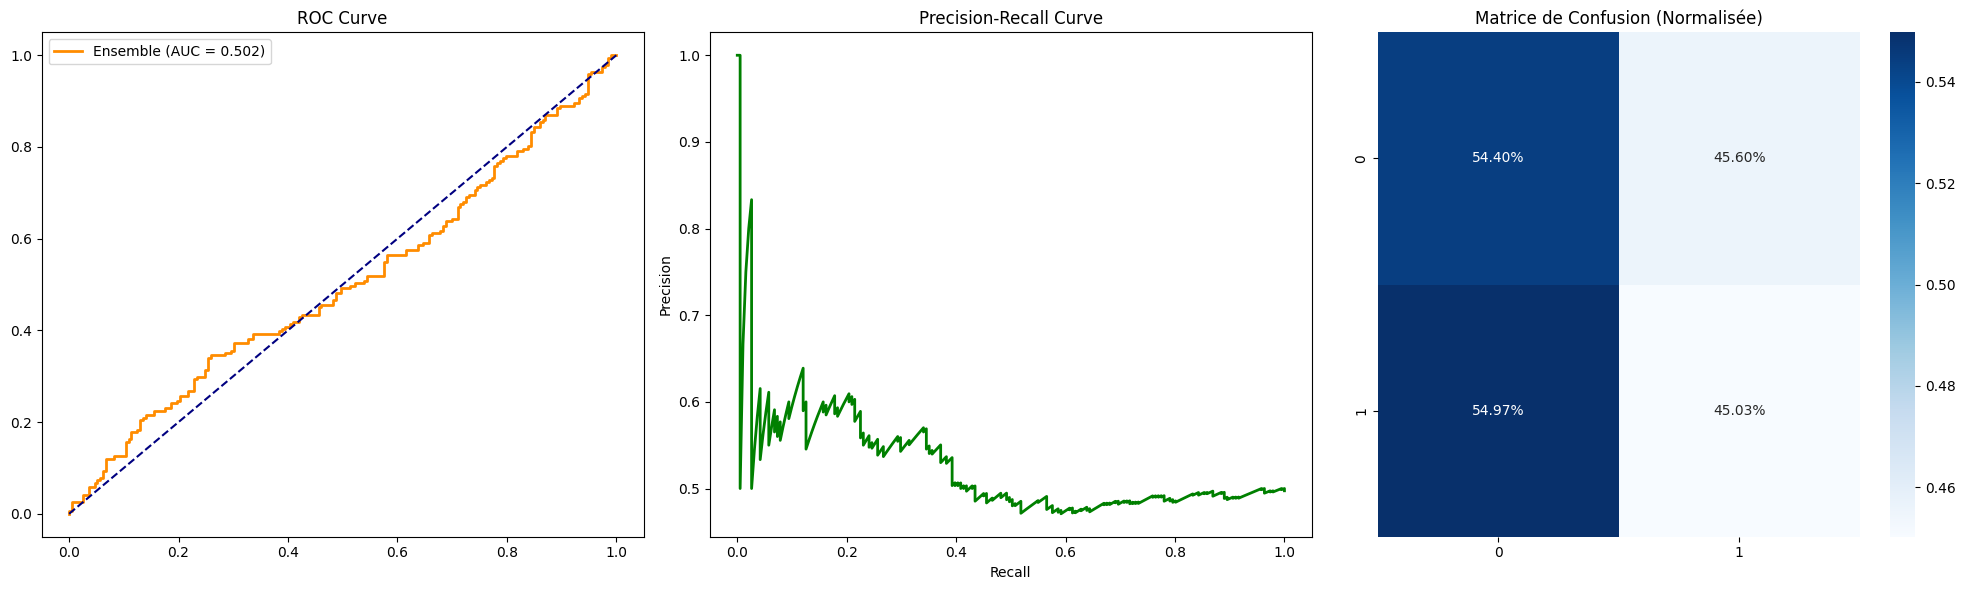

🎯 SCORE ROC-AUC ENSEMBLE : 0.5018


In [7]:
# ==============================================================================
# CELLULE 7 : ÉVALUATION VISUELLE COMPLÈTE
# ==============================================================================
print("\n5. Évaluation de la performance (Ensemble)...")

# Prédictions individuelles
pred_xgb = model_xgb.predict_proba(X_test)[:, 1]
pred_lgb = model_lgb.predict_proba(X_test)[:, 1]

# Prédiction ENSEMBLE (Moyenne)
y_pred_proba = (pred_xgb + pred_lgb) / 2.0

# Calcul Métriques
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# --- PLOTS ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', linestyle='--')
axes[0].set_title('ROC Curve')
axes[0].legend()

# 2. Precision-Recall
axes[1].plot(recall, precision, color='green', lw=2)
axes[1].set_title('Precision-Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')

# 3. Confusion Matrix
y_pred_bin = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_bin, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', ax=axes[2])
axes[2].set_title('Matrice de Confusion (Normalisée)')

plt.tight_layout()
plt.show()

print(f"🎯 SCORE ROC-AUC ENSEMBLE : {roc_auc:.4f}")

In [8]:
# ==============================================================================
# CELLULE 8 : ENTRAÎNEMENT FINAL (FULL DATA) & SAUVEGARDE
# ==============================================================================
print("\n6. Re-training sur 100% des données pour la soumission...")

# On concatène tout
X_full_lean = X[top_features] # On garde les mêmes features
y_full = y
w_full = w_all

# On limite le nombre d'arbres (basé sur ce qu'on a vu en training, ex: 800)
# XGBoost Final
final_xgb = XGBClassifier(n_estimators=800, max_depth=4, learning_rate=0.02, 
                          subsample=0.7, colsample_bytree=0.7, gamma=0.5, reg_alpha=0.5,
                          scale_pos_weight=scale_ratio, n_jobs=-1, random_state=42)
final_xgb.fit(X_full_lean, y_full, sample_weight=w_full.values)

# LightGBM Final
final_lgb = LGBMClassifier(n_estimators=800, max_depth=4, learning_rate=0.02,
                           subsample=0.7, colsample_bytree=0.7, scale_pos_weight=scale_ratio,
                           n_jobs=-1, random_state=42, verbose=-1)
final_lgb.fit(X_full_lean, y_full, sample_weight=w_full.values)

# Sauvegarde
if not os.path.exists('../submission'): os.makedirs('../submission')

joblib.dump(final_xgb, '../submission/model_xgb.pkl')
joblib.dump(final_lgb, '../submission/model_lgb.pkl')
joblib.dump(top_features, '../submission/features_list.pkl')

print("💾 Fichiers sauvegardés : model_xgb.pkl, model_lgb.pkl, features_list.pkl")
print("👉 N'oublie pas de mettre à jour ton main.py pour charger les DEUX modèles !")


6. Re-training sur 100% des données pour la soumission...
💾 Fichiers sauvegardés : model_xgb.pkl, model_lgb.pkl, features_list.pkl
👉 N'oublie pas de mettre à jour ton main.py pour charger les DEUX modèles !
